In [82]:
!unzip samples.zip

Archive:  samples.zip
   creating: samples/0/
  inflating: samples/0/0_1.wav       
  inflating: samples/0/0_10.wav      
  inflating: samples/0/0_11.wav      
  inflating: samples/0/0_12.wav      
  inflating: samples/0/0_13.wav      
  inflating: samples/0/0_14.wav      
  inflating: samples/0/0_15.wav      
  inflating: samples/0/0_16.wav      
  inflating: samples/0/0_17.wav      
  inflating: samples/0/0_18.wav      
  inflating: samples/0/0_19.wav      
  inflating: samples/0/0_2.wav       
  inflating: samples/0/0_20.wav      
  inflating: samples/0/0_21.wav      
  inflating: samples/0/0_22.wav      
  inflating: samples/0/0_23.wav      
  inflating: samples/0/0_24.wav      
  inflating: samples/0/0_25.wav      
  inflating: samples/0/0_26.wav      
  inflating: samples/0/0_27.wav      
  inflating: samples/0/0_28.wav      
  inflating: samples/0/0_29.wav      
  inflating: samples/0/0_3.wav       
  inflating: samples/0/0_30.wav      
  inflating: samples/0/0_31.wav      
  in

In [116]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Definindo as pastas
data_path = 'samples'
labels = ['frente', 'tras', 'esquerda', 'direita', 'mais', 'menos', 'parar', 'rodar']
spectrogram_path = 'spectrograms'
train_path = os.path.join(spectrogram_path, 'train')
val_path = os.path.join(spectrogram_path, 'val')
img_height, img_width = 128, 128  # Tamanho das imagens ajustado para 128x128

# Criar pastas para salvar os espectrogramas
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
for label in labels:
    os.makedirs(os.path.join(train_path, label), exist_ok=True)
    os.makedirs(os.path.join(val_path, label), exist_ok=True)

In [119]:
# Carregar dados de áudio e salvar espectrogramas
audio_data = []
audio_labels = []
desired_length = 60000  # Define a duração padrão desejada (por exemplo, 1 segundo a 16 kHz)

for label_index, label in enumerate(labels):
    folder_path = os.path.join(data_path, str(label_index))
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            y, sr = librosa.load(file_path, sr=None)
            y = pad_or_truncate(y, desired_length)
            audio_data.append(y)
            audio_labels.append(label_index)

audio_data = np.array(audio_data)
audio_labels = np.array(audio_labels)

# Verificar balanceamento do conjunto de dados
for label_index, label in enumerate(labels):
    print(f'Label {label}: {np.sum(audio_labels == label_index)} samples')

Label frente: 50 samples
Label tras: 50 samples
Label esquerda: 50 samples
Label direita: 50 samples
Label mais: 50 samples
Label menos: 50 samples
Label parar: 50 samples
Label rodar: 50 samples


In [120]:
# Dividir os dados em conjuntos de treinamento e validação
train_data, val_data, train_labels, val_labels = train_test_split(
    audio_data, audio_labels, test_size=0.2, random_state=42, stratify=audio_labels
)

# Salvar espectrogramas
for i, (audio, label) in enumerate(zip(train_data, train_labels)):
    label_name = labels[label]
    save_path = os.path.join(train_path, label_name, f'train_{i}.png')
    save_spectrogram(audio, sr, label_name, save_path)

for i, (audio, label) in enumerate(zip(val_data, val_labels)):
    label_name = labels[label]
    save_path = os.path.join(val_path, label_name, f'val_{i}.png')
    save_spectrogram(audio, sr, label_name, save_path)


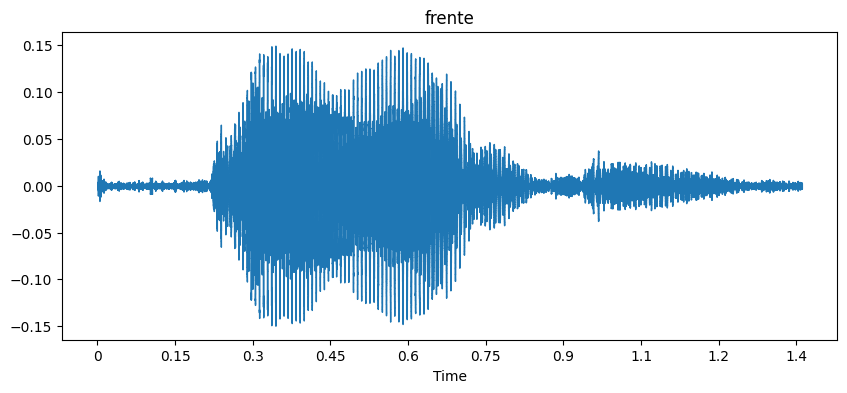

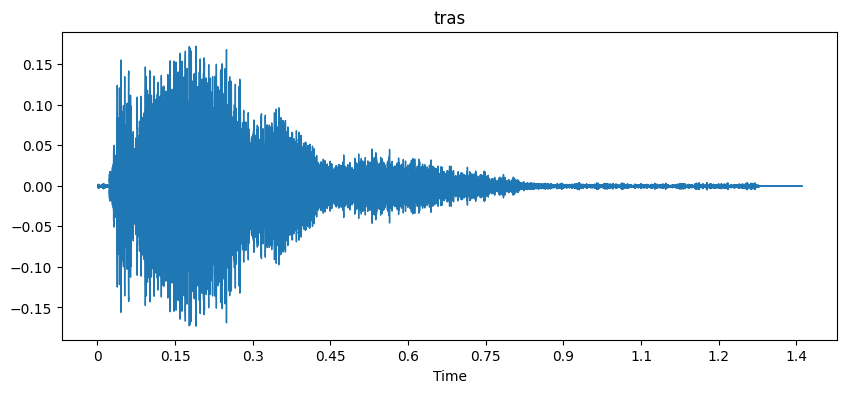

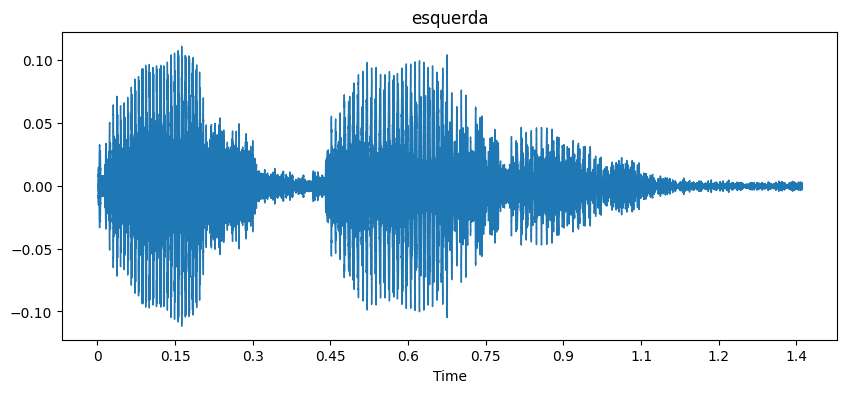

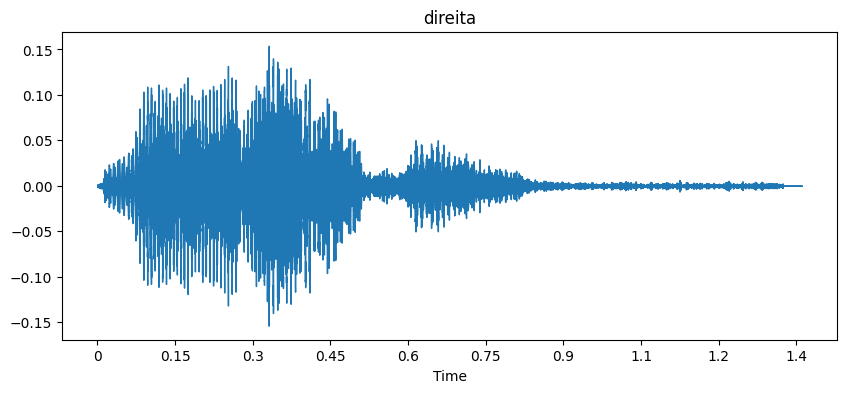

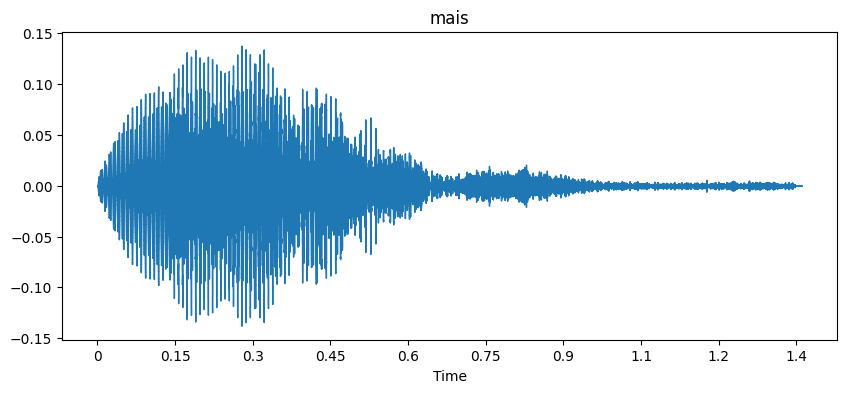

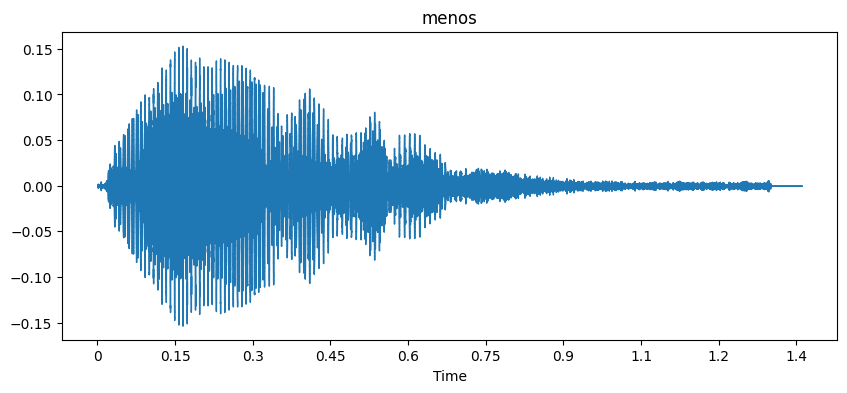

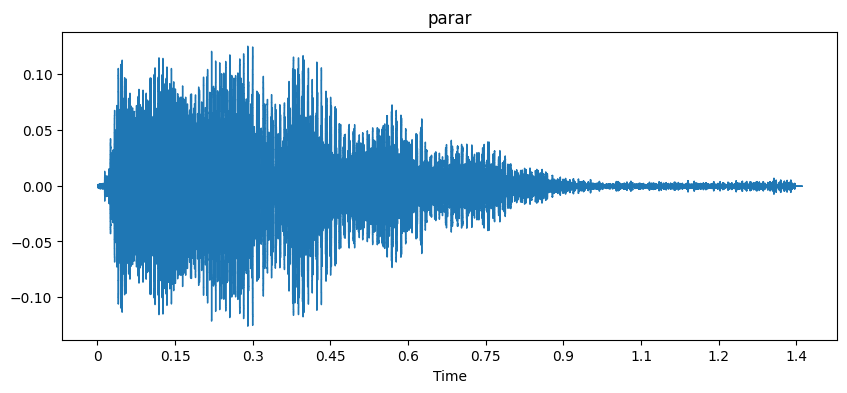

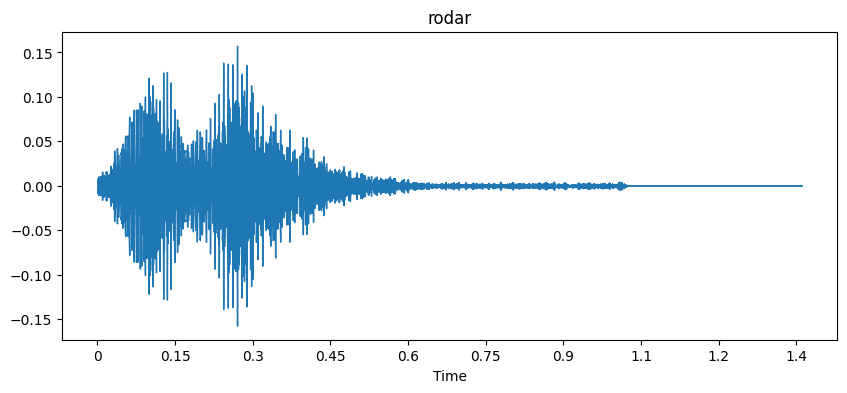

In [88]:
# Mostrar exemplo de áudios
def plot_waveform(audio, sr, title):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(title)
    plt.show()
    display(Audio(data=audio, rate=sr))

# Exibir os primeiros exemplos
for i in range(len(labels)):
    index = np.where(audio_labels == i)[0][0]
    plot_waveform(audio_data[index], sr, labels[i])


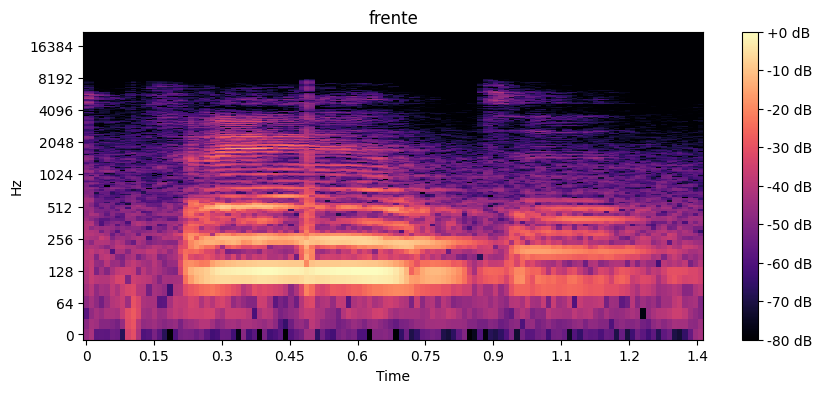

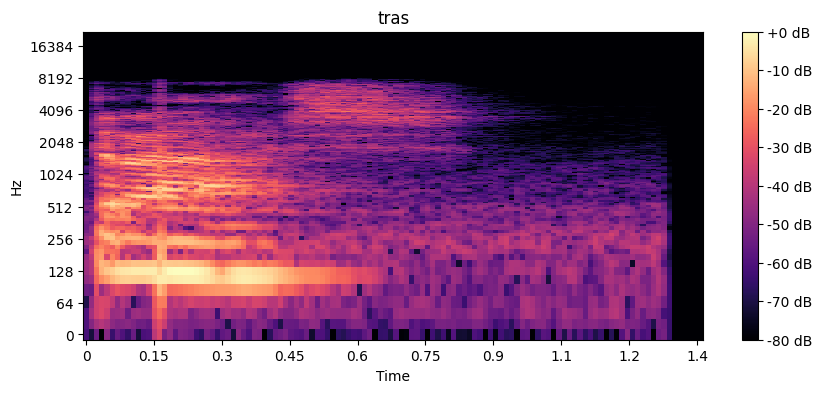

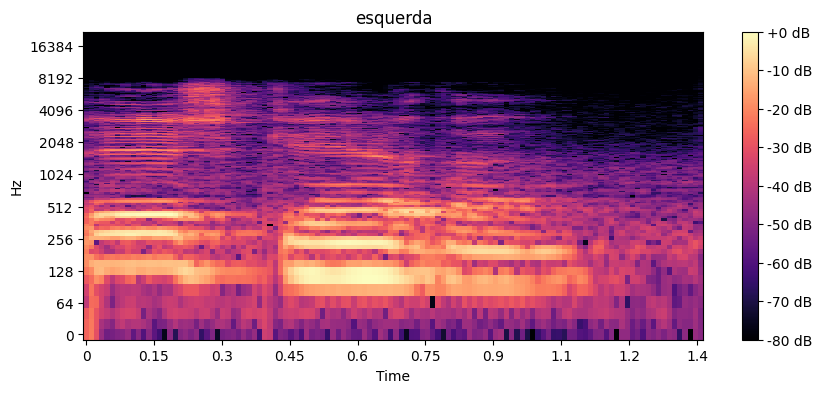

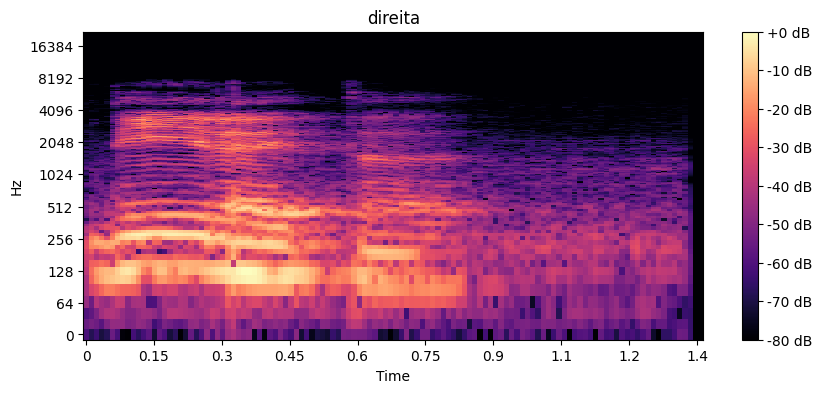

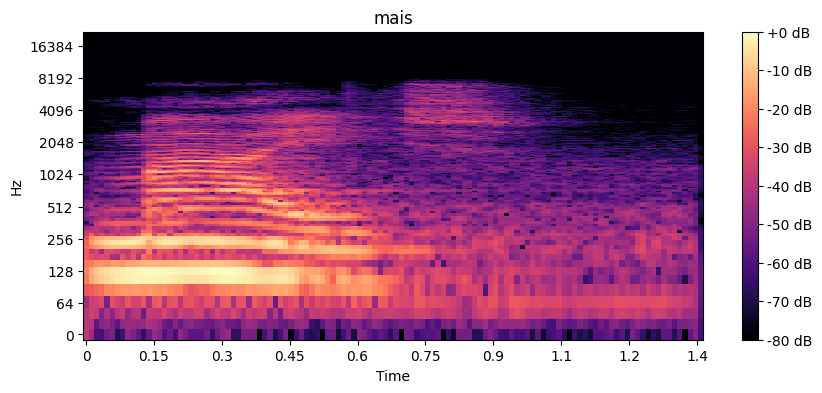

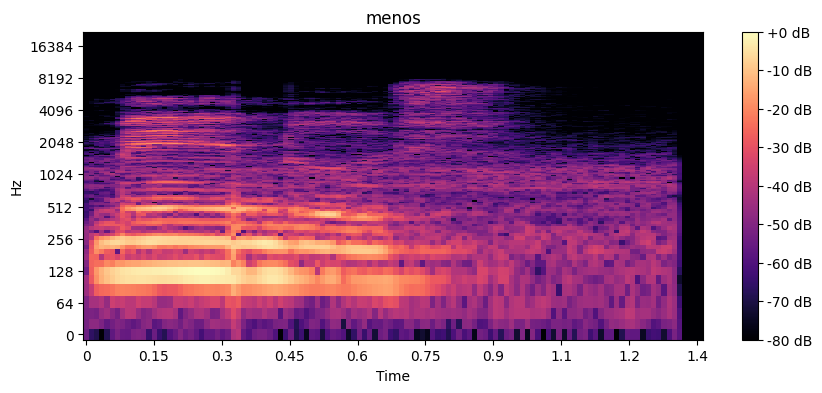

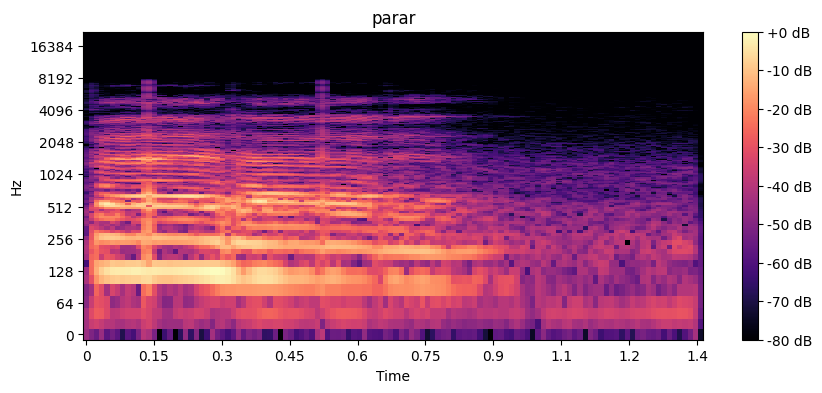

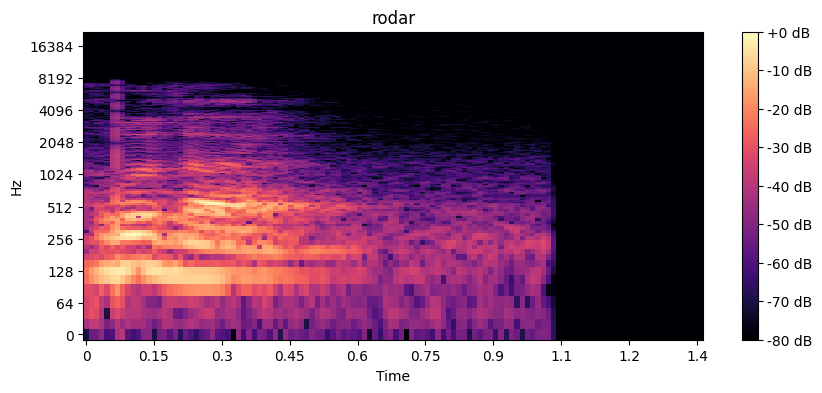

In [89]:
# Mostrar exemplo de espectrograma
def plot_spectrogram(audio, sr, title):
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

# Exibir os primeiros espectrogramas
for i in range(len(labels)):
    index = np.where(audio_labels == i)[0][0]
    plot_spectrogram(audio_data[index], sr, labels[i])


In [90]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

img_height = int(480/3) #432 #28
img_width = int(640/3)

checkpoint_path = 'FinalResNet50.h5'
checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Load ResNet50 model without pre-trained weights
pretrained_model = ResNet50(weights=None, include_top=False, input_shape=(img_height, img_width, 3), pooling='avg')

model = Sequential()
model.add(pretrained_model)
model.add(Dense(10, activation='softmax'))

model.summary()

model.compile(
    optimizer='adamax',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_15 (Dense)            (None, 10)                20490     
                                                                 
Total params: 23608202 (90.06 MB)
Trainable params: 23555082 (89.86 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [91]:
train_datagen = ImageDataGenerator(height_shift_range=15, samplewise_center=True, samplewise_std_normalization=True)
validation_datagen = ImageDataGenerator(height_shift_range=15, samplewise_center=True, samplewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=3,
    class_mode='sparse',
)

validation_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=3,
    class_mode='sparse',
)

Found 320 images belonging to 8 classes.
Found 80 images belonging to 8 classes.


In [92]:
# Treinar o modelo
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[checkpoint_callback], batch_size=32)

# Salvar o modelo
model.save('audio_classification_model.h5')

Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 2.2132 - accuracy: 0.3625
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to FinalResNet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 226s 2s/step - loss: 2.2132 - accuracy: 0.3625 - val_loss: 8.6063 - val_accuracy: 0.1250
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 1.2104 - accuracy: 0.6187
Epoch 2: val_accuracy improved from 0.12500 to 0.15000, saving model to FinalResNet50.h5
107/107 [==============================] - 199s 2s/step - loss: 1.2104 - accuracy: 0.6187 - val_loss: 7.4259 - val_accuracy: 0.1500
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 0.5761 - accuracy: 0.8031
Epoch 3: val_accuracy improved from 0.15000 to 0.25000, saving model to FinalResNet50.h5
107/107 [==============================] - 203s 2s/step - loss: 0.5761 - accuracy: 0.8031 - val_loss: 2.0852 - val_accuracy: 0.2500
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 0.2576 - accuracy: 0.9187
Epoch 4: val_accuracy improved from 0.25000 to 0.78750, saving model to FinalResNet50.h5
107/107 [==============================] - 215s 2

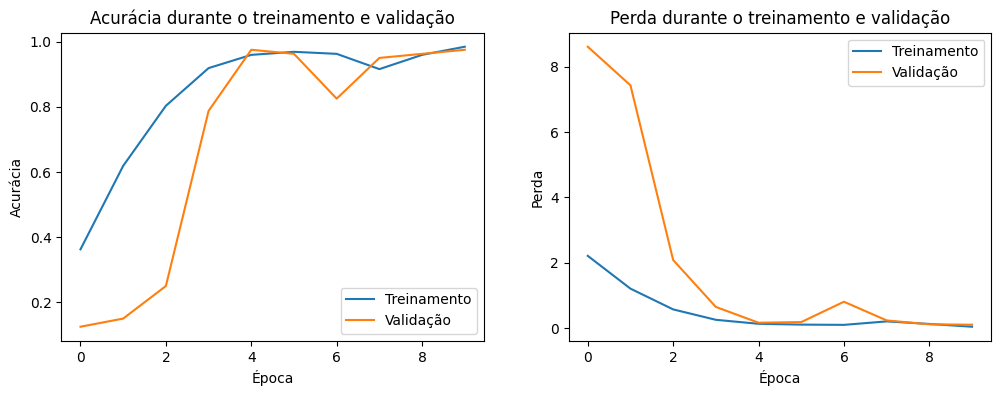

In [93]:
import matplotlib.pyplot as plt

# Função para plotar as curvas de acurácia e perda
def plot_history(history):
    # Acurácia
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Treinamento')
    plt.plot(history.history['val_accuracy'], label='Validação')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.title('Acurácia durante o treinamento e validação')

    # Perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Treinamento')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    plt.title('Perda durante o treinamento e validação')

    plt.show()

# Plotar as curvas de acurácia e perda
plot_history(history)


27/27 [==============================] - 29s 841ms/step


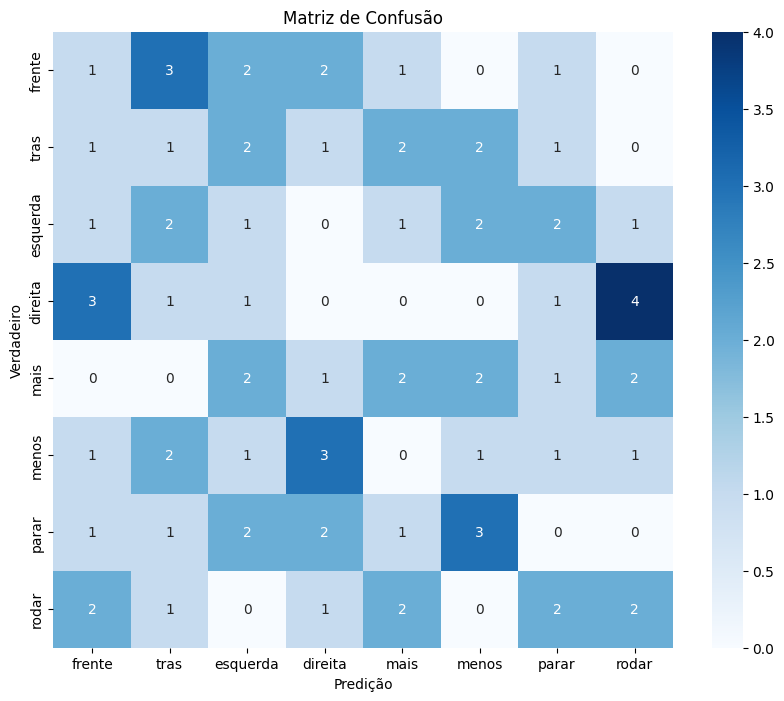

In [95]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Gerar previsões no conjunto de validação
val_predictions = model.predict(validation_generator)
val_predictions = np.argmax(val_predictions, axis=1)

# Obter os rótulos reais
val_labels = validation_generator.classes

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()


In [96]:
from sklearn.metrics import classification_report

# Gerar relatório de classificação
class_report = classification_report(val_labels, val_predictions, target_names=labels)
print('Relatório de Classificação:')
print(class_report)


Relatório de Classificação:
              precision    recall  f1-score   support

      frente       0.10      0.10      0.10        10
        tras       0.09      0.10      0.10        10
    esquerda       0.09      0.10      0.10        10
     direita       0.00      0.00      0.00        10
        mais       0.22      0.20      0.21        10
       menos       0.10      0.10      0.10        10
       parar       0.00      0.00      0.00        10
       rodar       0.20      0.20      0.20        10

    accuracy                           0.10        80
   macro avg       0.10      0.10      0.10        80
weighted avg       0.10      0.10      0.10        80

